<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a>

#  Прогнозирование заказов такси

Компания «Taxi 888» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем нужные библиотеки и модули для дальнейшей работы:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим хронологическую последовательность временного ряда:

In [3]:
data.index.is_monotonic

True

Выполним ресемплирование по одному часу. Выведем первые 5 строк датафрейма:

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
print('Временной промежуток данных:', data.index.min(), '|', data.index.max())

Временной промежуток данных: 2018-03-01 00:00:00 | 2018-08-31 23:00:00


**Вывод:** мы импортировали необходимые библиотеки и модули, загрузили данные и выполнили их ресемплирование по одному часу, также проверили хронологическую последовательность временного ряда с помощью `is_monotonic`

## Анализ

Выведем статистические данные по таблице:

In [6]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Из данных следует, что в среднем за час поступает 84 заказа, максимальное количество заказов в час - 462

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики временного ряда и проанализируем данные:

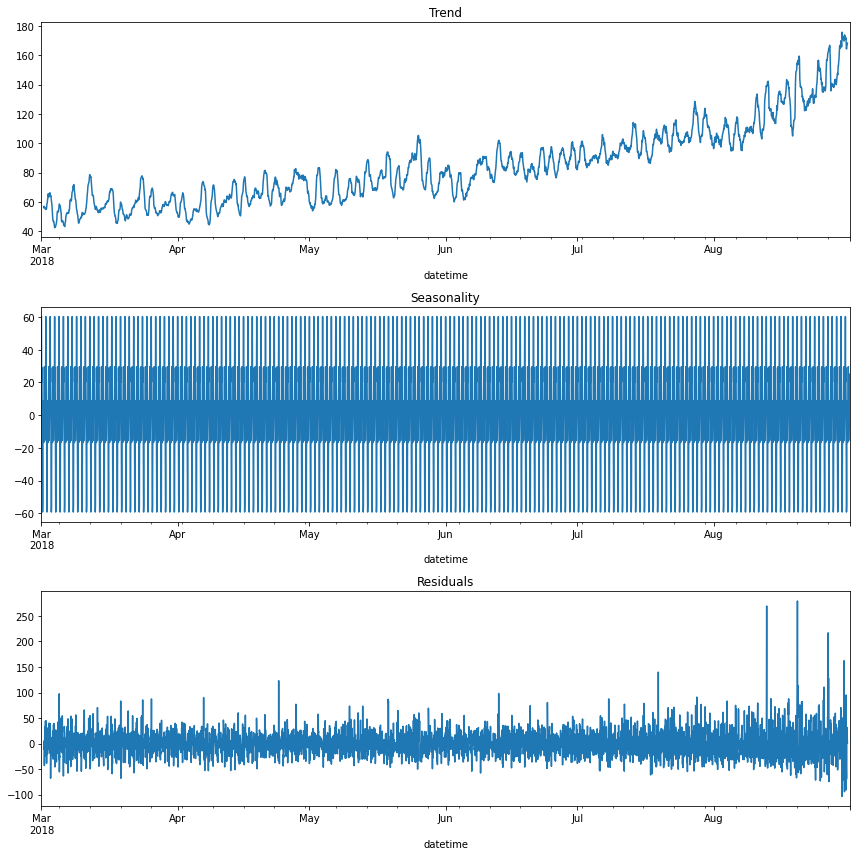

In [7]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Прослеживается возрастающий тренд, но в таком масштабе трудно оценить сезонную составляющую. Расмотрим срез данных за последние несколько дней августа:

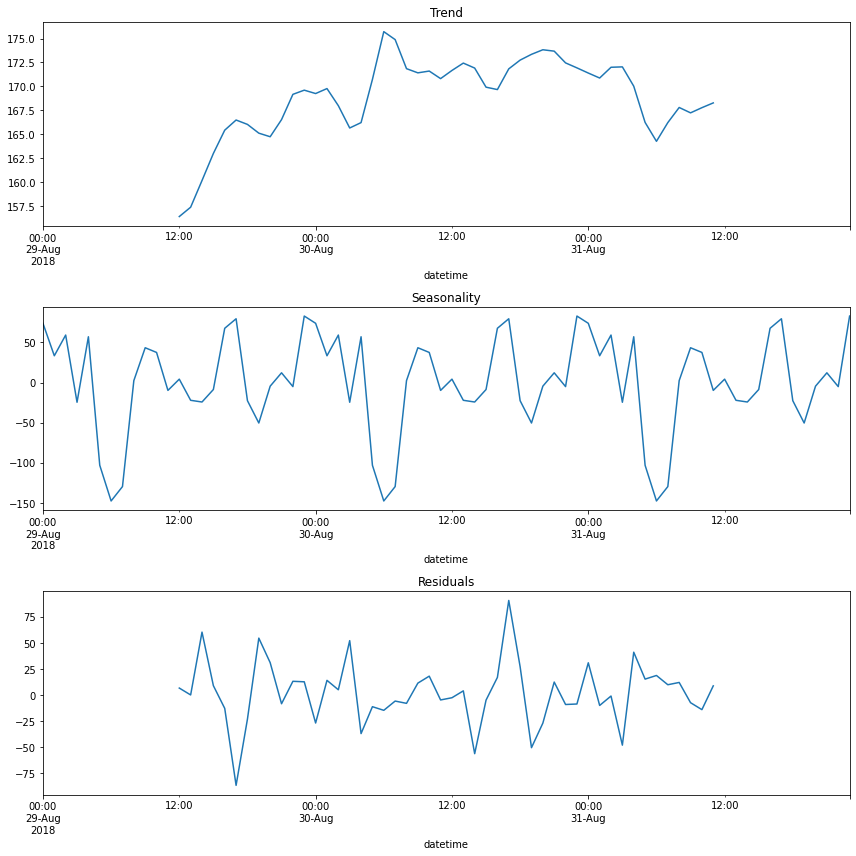

In [8]:
decomposed = seasonal_decompose(data['2018-08-29':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Количество заказов резко падает с 12 ночи до 6 утра, возрастает в утренние часы, достигая утреннего пика в районе 9-10 часов. Далее идет некоторое снижение до 14 часов, с последующим ростом до максимальных значений в районе 17-18 часов. Дальше количество заказов опять снижается до 20 часов и начинает расти в вечерние часы, достигая пика в районе 23:00 - 00:00 часов ночи.

**Вывод:** 
- мы проанализировали статистические данные с помощью метода `describe` и выяснили, что в среднем за час поступает 84 заказа, максимальное количество заказов в час - 462
- разложили данные на три составляющие: тренд, сезонность и остаток, построили графики временного ряда и выяснили, что прослеживается возрастающий тренд, но в таком масштабе трудно оценить сезонную составляющую
- дополнительно расмотрели срез данных за последние несколько дней августа и сделали вывод о том, что количество заказов резко падает с 12 ночи до 6 утра, возрастает в утренние часы, достигая утреннего пика в районе 9-10 часов. Далее идет некоторое снижение до 14 часов, с последующим ростом до максимальных значений в районе 17-18 часов. Дальше количество заказов опять снижается до 20 часов и начинает расти в вечерние часы, достигая пика в районе 23:00 - 00:00 часов ночи.

## Обучение

Создадим функцию для признаков: час, день недели, месяц, отстающие значения и скользящее среднее.

In [9]:
def make_features(data, max_lag, rolling_window_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_window_size).mean()
    data.dropna(inplace=True)
    return data

In [10]:
make_features(data,10,10).head()

,num_orders,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


Разделим данные на обучающую и тестовую выборки, размер тестовой выборки сделаем 10%:

In [11]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

Проверим получившиеся размеры выборок:

In [12]:
print(f'Размер обучающей выборки: {len (features_train) / len(data):.0%}')
print(f'Размер тестовой выборки: {len (features_test) / len(data):.0%}')

Размер обучающей выборки: 90%
Размер тестовой выборки: 10%


Проверим правильность расположения временных рядов, чтобы начало тестовой выборки следовало за окончанием обучающей

In [13]:
display(features_train.tail(1))
features_test.head(1)

,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 14:00:00,0,14,8,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0


,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 15:00:00,0,15,8,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9


Создадим константную модель, она всегда будет предсказывать среднее значение `num_orders`, рассчитаем RMSE для модели:

In [14]:
print('RMSE константной модели на тестовой выборке:',
      (mean_squared_error(target_test, pd.Series(target_train.mean(), index=target_test.index)) ** 0.5).round(2))

RMSE константной модели на тестовой выборке: 84.78


Обучим модель линейной регрессии, посчитаем RMSE модели. Обучение будем проводить с использованием кросс-валидации:

In [15]:
lm = LinearRegression()
print(f'''RMSE для LinearRegression на тренировочной выборке''', cross_val_score(lm, features_train,
                                                                             target_train,
                                                                             cv = TimeSeriesSplit(n_splits=9),
                                                                             n_jobs = -1,
                                                                             scoring ='neg_root_mean_squared_error').mean()*-1)

RMSE для LinearRegression на тренировочной выборке 31.04140682821855


In [16]:
lm.fit(features_train, target_train)
preds_lm = lm.predict(features_train)
mse_lm = mean_squared_error(target_train, preds_lm)
print('RMSE для линейной модели на валидационной выборке:', round((mse_lm) ** 0.5, 5))

RMSE для линейной модели на валидационной выборке: 30.38156


Обучим линейную модель RidgeCV, подобрав лучшее значение alpha и n_splits для cv:

In [17]:
start_rmse = -(cross_val_score(RidgeCV(alphas=[0.1]), features_train, target_train, cv=TimeSeriesSplit(n_splits=2),
                                n_jobs=-1, scoring='neg_root_mean_squared_error').mean())
best_alpha = []
best_rmse = 0
best_n_split = []
alphass = np.arange(0.1, 1, 0.1)
n_splits_values = np.arange(2, 10, 1)
for alphas in alphass:
    for n_splits in n_splits_values:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        ridge = RidgeCV(alphas=alphas)
        rmse = -cross_val_score(ridge, features_train, target_train, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error').mean()
        if rmse <= start_rmse:
            best_alpha = alphas
            best_n_split = n_splits
            best_rmse = rmse
print('RMSE и лучшие параметры RidgeCV на тренировочной выборке: alpha={:.1f}, n_splits={}, RMSE={:.5f}'.format(best_alpha,
                                                                                                      best_n_split,
                                                                                                      best_rmse))

RMSE и лучшие параметры RidgeCV на тренировочной выборке: alpha=0.9, n_splits=9, RMSE=31.04133


In [18]:
tscv = TimeSeriesSplit(n_splits=9)
ridgecv = RidgeCV(alphas=[0.9], cv=tscv)
ridgecv.fit(features_train, target_train)
preds_rg = ridgecv.predict(features_train)
mse_rg = mean_squared_error(target_train, preds_rg)
print('RMSE для RidgeCV модели на валидационной выборке:', round((mse_rg) ** 0.5, 5))

RMSE для RidgeCV модели на валидационной выборке: 30.38156


Результат RMSE RidgeCV практически такой же как у модели линейной регрессии

Обучим модель Lasso, также предварительно подобрав лучшее значение alpha и n_splits в cv:

In [19]:
start_rmse = -(cross_val_score(Lasso(alpha=0.1), features_train, target_train, cv=TimeSeriesSplit(n_splits=2),
                                n_jobs=-1, scoring='neg_root_mean_squared_error').mean())
best_alpha = []
best_rmse = 0
best_n_split = []
alphass = np.arange(0.1, 1, 0.1)
n_splits_values = np.arange(2, 10, 1)
for alpha in alphass:
    for n_splits in n_splits_values:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        lasso = Lasso(alpha=alpha)
        rmse = -cross_val_score(lasso, features_train, target_train, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error').mean()
        if rmse <= start_rmse:
            best_alpha = alpha
            best_n_split = n_splits
            best_rmse = rmse
print('RMSE и лучшие параметры Lasso на тренировочной выборке: alpha={:.1f}, n_splits={}, RMSE={:.5f}'.format(best_alpha,
                                                                                                      best_n_split,
                                                                                                      best_rmse))

RMSE и лучшие параметры Lasso на тренировочной выборке: alpha=0.9, n_splits=9, RMSE=31.19173


In [20]:
lasso = Lasso(alpha=0.9)
lasso.fit(features_train, target_train)
preds_ls = lasso.predict(features_train)
mse_ls = mean_squared_error(target_train, preds_ls)
print('RMSE для Lasso модели на валидационной выборке:', round((mse_ls) ** 0.5, 5))

RMSE для Lasso модели на валидационной выборке: 30.39345


RMSE всех трех линейных моделей практически одинаковы. Оптимизируем отставание до 48, а скользящее среднее оставим равным 10 по умолчанию:

In [21]:
data_opt = make_features(data, max_lag=48, rolling_window_size=10)
features_opt = data_opt.drop('num_orders', axis=1)
target_opt = data_opt['num_orders']
features_opt_train, features_opt_test, target_opt_train, target_opt_test = train_test_split(features_opt,
                                                                                            target_opt,
                                                                                            shuffle=False, test_size=0.1)

In [22]:
lm=LinearRegression()
rmse_lm = cross_val_score(lm, features_opt_train, target_opt_train, cv=TimeSeriesSplit(n_splits=3), n_jobs = -1,
                          scoring ='neg_root_mean_squared_error')
print('RMSE для модели линейной регрессии на тренировочной выборке:', round((-rmse_lm.mean()), 5))
lm.fit(features_opt_train, target_opt_train)
preds_lm = lm.predict(features_opt_train)
mse_lm = mean_squared_error(target_opt_train, preds_lm)
print('RMSE для модели линейной регрессии на валидационной выборке:', round((mse_lm) ** 0.5, 5))

RMSE для модели линейной регрессии на тренировочной выборке: 25.32853
RMSE для модели линейной регрессии на валидационной выборке: 23.3901


In [23]:
ridge=RidgeCV(alphas=[0.9])
rmse_ridge = cross_val_score(ridge, features_opt_train, target_opt_train, cv=tscv, n_jobs=-1,
                             scoring='neg_root_mean_squared_error')
print('RMSE для RidgeCV модели на тренировочной выборке:', round((-rmse_ridge.mean()), 5))
ridge.fit(features_opt_train, target_opt_train)
preds_ridge = ridge.predict(features_opt_train)
mse_ridge = mean_squared_error(target_opt_train, preds_ridge)
print('RMSE для RidgeCV модели на валидационной выборке:', round((mse_ridge) ** 0.5, 5))

RMSE для RidgeCV модели на тренировочной выборке: 24.14239
RMSE для RidgeCV модели на валидационной выборке: 23.39026


In [24]:
lasso=Lasso(alpha=0.9)
rmse_lasso = cross_val_score(lasso, features_opt_train, target_opt_train, cv=tscv,
                             n_jobs=-1,scoring='neg_root_mean_squared_error')
print('RMSE для Lasso модели на тренировочной выборке:', round((-rmse_lasso.mean()), 5))
lasso.fit(features_opt_train, target_opt_train)
preds_lasso = lasso.predict(features_opt_train)
mse_lasso = mean_squared_error(target_opt_train, preds_lasso)
print('RMSE для Lasso модели на валидационной выборке:', round((mse_lasso) ** 0.5, 5))

RMSE для Lasso модели на тренировочной выборке: 24.12652
RMSE для Lasso модели на валидационной выборке: 23.43322


**Вывод:**
- создадили функцию для признаков: час, день недели, месяц, отстающие значения и скользящее среднее
- разделили данные на обучающую и тестовую выборки, проверили получившиеся размеры выборок и правильность расположения временных рядов
- создали константную модель, рассчитали для нее RMSE
- с помощью кросс-валидации обучили модели линейной регрессии, Ridge и Lasso, посчитали их RMSE и выяснили, что результаты всех моделей практически одинаковы и равны 30.38, у модели Lasso результат немного хуже - 30.39
- с помощью оптимизации отставания и скользящего среднего улучшили показатели метрики RMSE по всем моделям. LinearRegression (23.3901), RidgeCV (23.3902), Lasso (23.4332). На данном этапе лучший показатель RMSE у модели линейной регрессии, тестировать будем ее

## Тестирование

Проведем тестирование модели LinearRegression:

In [25]:
preds_lm_test = lm.predict(features_opt_test)
mse_lm_test = mean_squared_error(target_opt_test, preds_lm_test)
print('RMSE для Linear модели на тестовой выборке:', round((mse_lm_test) ** 0.5, 5))

RMSE для Linear модели на тестовой выборке: 42.6378


Построим график прогнозных значений модели и фактических:

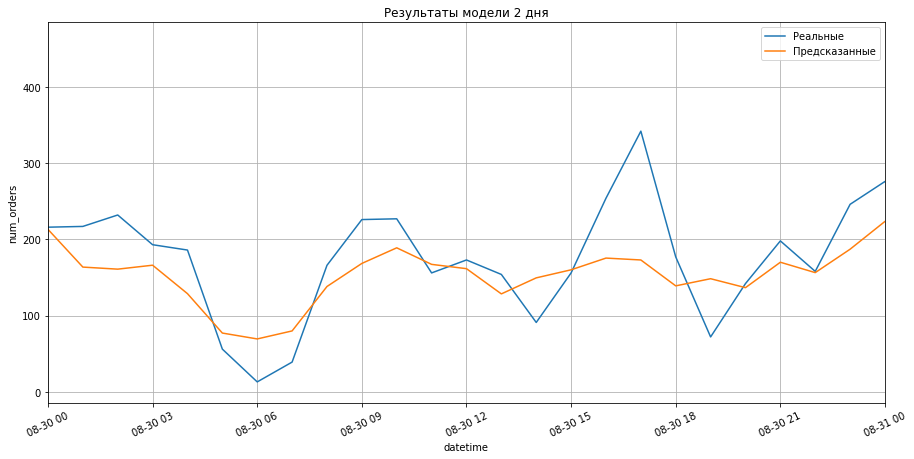

In [26]:
def visual_comparison(lm, x = features_opt_test, y=target_opt_test, x_lim_left='2018-08-30', x_lim_right='2018-08-31'):
    plt.figure(figsize=(15, 7))
    sns.lineplot(x = y.index, y = y, label='Реальные')
    sns.lineplot(x = y.index, y = lm.predict(x), label='Предсказанные')
    plt.xticks(rotation=25)
    plt.xlim(pd.to_datetime(x_lim_left),pd.to_datetime(x_lim_right))
    plt.grid()
    plt.title('Результаты модели 2 дня')
visual_comparison(lm)

**Вывод:**
- мы провели тестирование лучшей модели и выяснили, что результат метрики RMSE на тестовой выборке хуже, чем на обучающей, это значит, что модель переобучена
- результат модели LinearRegression не превышает 48 и равен 42.63
- построили график, чтобы сравнить предсказанные значения с фактическими, модель предсказывает сохраняя тенденцию

**Вывод по проекту:**
- импортировали необходимые библиотеки и модули, загрузили данные и выполнили их ресемплирование по одному часу
- проанализировали статистические данные с помощью метода describe и выяснили, что в среднем за час поступает 84 заказа, максимальное количество заказов в час - 462
- разложили данные на три составляющие: тренд, сезонность и остаток, построили графики временного ряда и выяснили, что прослеживается возрастающий тренд, но в таком масштабе трудно оценить сезонную составляющую
- дополнительно расмотрели срез данных за последние несколько дней августа и сделали вывод о том, что количество заказов резко падает с 12 ночи до 6 утра, возрастает в утренние часы, достигая утреннего пика в районе 9-10 часов. Далее идет некоторое снижение до 14 часов, с последующим ростом до максимальных значений в районе 17-18 часов. Дальше количество заказов опять снижается до 20 часов и начинает расти в вечерние часы, достигая пика в районе 23:00 - 00:00 часов ночи
- создадили функцию для признаков: час, день недели, месяц, отстающие значения и скользящее среднее
- разделили данные на обучающую и тестовую выборки, проверили получившиеся размеры выборок и правильность расположения временных рядов
- создали константную модель, рассчитали для нее RMSE
- с помощью кросс-валидации обучили модели линейной регрессии, Ridge и Lasso, посчитали их RMSE и выяснили, что результаты всех моделей практически одинаковы и равны 30.38, у модели Lasso результат немного хуже - 30.39
- с помощью оптимизации отставания и скользящего среднего улучшили показатели метрики RMSE по всем моделям. LinearRegression (23.589), Ridge (23.598), Lasso (23.64). На данном этапе лучший показатель RMSE у модели линейной регрессии
- провели тестирование лучшей модели и выяснили, что результат метрики RMSE на тестовой выборке хуже, чем на обучающей, это значит, что модель переобучена
- результат модели LinearRegression не превышает 48 и равен 42.63
- построили график, чтобы сравнить предсказанные значения с фактическими, модель предсказывает сохраняя тенденцию